### Setup

In [57]:
import lib
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

from datetime import datetime, timedelta

l = lib.Offload()

### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

## CO2 level over complete measuring time
In buckets of 5 minutes, get information about the CO2 level in the classrooms over the complete measurement time.

In [2]:
co2_buckets_primar_eg_full = l.get_timebuckets_with_diff("Primarklasse_EG", datetime.utcfromtimestamp(0), datetime.now())
co2_buckets_primar_eg_full

,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff
0,2022-04-22 23:55:00+02:00,1098.40,NaN,1098.0,NaN
1,2022-04-23 00:00:00+02:00,1099.55,1.15,1098.5,0.5
2,2022-04-23 00:05:00+02:00,1096.64,-2.91,1097.0,-1.5
3,2022-04-23 00:10:00+02:00,1098.12,1.48,1098.0,1.0
4,2022-04-23 00:15:00+02:00,1096.36,-1.76,1098.0,0.0
...,...,...,...,...,...
5252,2022-05-14 23:05:00+02:00,1037.03,5.40,1037.0,5.0
5253,2022-05-14 23:10:00+02:00,1031.64,-5.39,1032.0,-5.0
5254,2022-05-14 23:15:00+02:00,1028.08,-3.56,1027.0,-5.0
5255,2022-05-14 23:20:00+02:00,1031.43,3.35,1032.0,5.0


## CO2 level during lessons
In buckets of 5 minutes, get information about the CO2 level in the classrooms, during lessons that where given.

For this analysis, we do not look at the room `Oberstufe`, as it is a multi-functional room (sometimes used for music lessons) and we know less reliably how many people where there during each lesson.

In [4]:
co2_primar_eg_lessons = l.get_timebuckets_for_timetable("Primarklasse_EG", l.timetables['Primar_EG'])
co2_primar_eg_lessons

,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff,lesson_uuid,people
0,2022-04-25 07:35:00+02:00,876.12,NaN,804.0,NaN,0,21
1,2022-04-25 07:40:00+02:00,794.53,-81.59,830.0,26.0,0,21
2,2022-04-25 07:45:00+02:00,994.19,199.66,1007.0,177.0,0,21
3,2022-04-25 07:50:00+02:00,1060.48,66.29,1050.5,43.5,0,21
4,2022-04-25 07:55:00+02:00,1185.90,125.42,1165.0,114.5,0,21
...,...,...,...,...,...,...,...
4,2022-05-13 11:10:00+02:00,925.25,-12.55,940.0,-7.0,70,21
5,2022-05-13 11:15:00+02:00,1000.81,75.56,1005.0,65.0,70,21
6,2022-05-13 11:20:00+02:00,933.20,-67.61,911.0,-94.0,70,21
7,2022-05-13 11:25:00+02:00,944.86,11.66,952.0,41.0,70,21


In [5]:
co2_primar_og1_lessons = l.get_timebuckets_for_timetable("Primarklasse_OG1", l.timetables['Primar_OG1'])
co2_primar_og1_lessons

,ts,co2_mean,co2_mean_diff,co2_median,co2_median_diff,lesson_uuid,people
0,2022-04-25 07:35:00+02:00,529.76,NaN,523.0,NaN,0,22
1,2022-04-25 07:40:00+02:00,546.22,16.46,547.0,24.0,0,22
2,2022-04-25 07:45:00+02:00,535.00,-11.22,535.0,-12.0,0,22
3,2022-04-25 07:50:00+02:00,559.46,24.46,546.0,11.0,0,22
4,2022-04-25 07:55:00+02:00,598.34,38.88,599.0,53.0,0,22
...,...,...,...,...,...,...,...
4,2022-05-13 11:10:00+02:00,475.39,-35.56,477.0,-43.0,88,11
5,2022-05-13 11:15:00+02:00,512.58,37.19,516.0,39.0,88,11
6,2022-05-13 11:20:00+02:00,743.86,231.28,775.0,259.0,88,11
7,2022-05-13 11:25:00+02:00,592.86,-151.00,594.0,-181.0,88,11


Dropping all lessons that have any decrease in CO2 level: We want to keep only the lessons when no kind of ventilation (windows, door) occurred

In [13]:
def keep_non_vent_lessons(df):
    # collect id's of lessons to drop
    lessons_to_drop = []

    for index, bucket in df.iterrows():
      lesson_id = bucket['lesson_uuid']
      co2_median_diff = bucket['co2_median_diff']

      if co2_median_diff and float(bucket['co2_median_diff']) < 0:
        if lesson_id not in lessons_to_drop:
          lessons_to_drop.append(lesson_id)

    # create new df only with lessons that had a steady CO2 increase
    df_cleaned = df.copy()
    for lesson in lessons_to_drop:
        df_cleaned = df_cleaned.loc[~df_cleaned['lesson_uuid'].isin(lessons_to_drop)]

    # reset index
    df_cleaned = df_cleaned.reset_index()
    return df_cleaned

data_no_vent_lessons_eg = keep_non_vent_lessons(co2_primar_eg_lessons)
data_no_vent_lessons_og1 = keep_non_vent_lessons(co2_primar_og1_lessons)

### Plots
Plotting the distribution of the CO2 changes occurring when no ventilation is going on over whole lessons.

#### Primar EG

{'whiskers': [<matplotlib.lines.Line2D at 0x7f83c91c6bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f83c91d4190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f83c91c68e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f83c91d4730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f83c91d4a00>],
 'means': []}

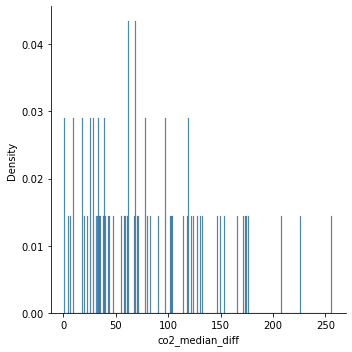

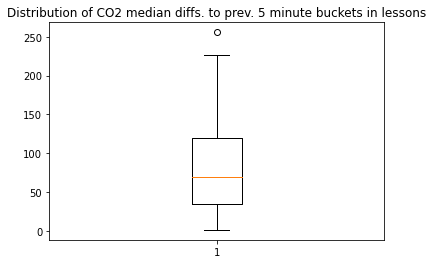

In [14]:
# Distribution
sns.displot(data = data_no_vent_lessons_eg, x = 'co2_median_diff', stat="density", common_norm=False)

# Boxplot
fig1, ax1 = plt.subplots()
ax1.set_title('Distribution of CO2 median diffs. to prev. 5 minute buckets in lessons')
ax1.boxplot(data_no_vent_lessons_eg['co2_median_diff'].dropna())

#### Primar OG1

{'whiskers': [<matplotlib.lines.Line2D at 0x7f83c8d01580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f83c8d01b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f83c8d012b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f83c8d0f100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f83c8d0f3d0>],
 'means': []}

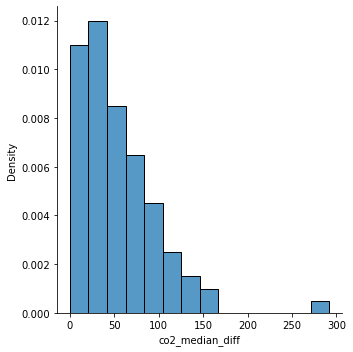

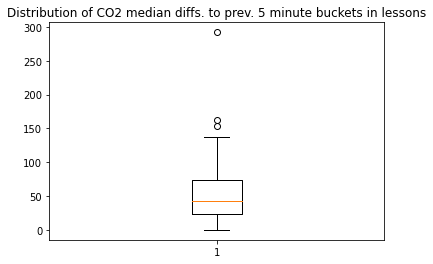

In [11]:
sns.displot(data = data_no_vent_lessons_og1, x = 'co2_median_diff', stat="density", common_norm=False)

# Boxplot
fig1, ax1 = plt.subplots()
ax1.set_title('Distribution of CO2 median diffs. to prev. 5 minute buckets in lessons')
ax1.boxplot(data_no_vent_lessons_og1['co2_median_diff'].dropna())

### Overview
Creating an overview of all the lessons without ventilation, and calculating their important properties.

We choose to base our analysis on the median: The mean takes is disturbed by outliers (like people actively increasing the CO2 level by blowing at the sensor)

#### Primar EG

In [15]:
overview_no_vent_lessons_eg = data_no_vent_lessons_eg.groupby(['lesson_uuid'])[['co2_median', 'co2_median_diff', 'ts', 'people']].agg(
    {'co2_median': ['min', 'max', 'mean'], 'co2_median_diff': ['min', 'max', 'mean'], 'ts': ['min', 'max'], 'people': 'first'}).dropna()
overview_no_vent_lessons_eg

co2_median                      co2_median_diff                   \
                   min     max         mean             min    max      mean   
lesson_uuid                                                                    
0                804.0  1165.0   971.300000            26.0  177.0   90.2500   
5                870.0  1341.0  1106.200000            69.0  166.0  117.7500   
7               1113.0  1777.0  1417.944444             5.0  154.0   83.0000   
12              1133.0  1541.0  1330.700000            61.0  146.5  102.0000   
16               615.0  1040.0   824.444444            20.0  124.0   53.1250   
17              1218.0  1739.0  1489.600000            69.0  208.0  130.2500   
27               600.0   868.0   751.666667            35.0   78.0   53.6000   
28               959.0  1357.0  1099.000000             1.0  226.0   99.5000   
29               927.0  2014.0  1518.222222            78.0  256.0  135.8750   
37               895.0  1208.0  1044.722222            18.0   71.0   39.1250   
47              1241.0  1536.5  1394.611111             1.0   96.5   36.9375   
53               952.0  1281.0  1115.200000            10.0  174.0   82.2500   

                                   ts                           people  
                                  min                       max  first  
lesson_uuid                                                             
0           2022-04-25 07:35:00+02:00 2022-04-25 07:55:00+02:00     21  
5           2022-04-26 07:35:00+02:00 2022-04-26 07:55:00+02:00     21  
7           2022-04-26 08:55:00+02:00 2022-04-26 09:35:00+02:00     21  
12          2022-04-27 07:35:00+02:00 2022-04-27 07:55:00+02:00     21  
16          2022-04-27 10:50:00+02:00 2022-04-27 11:30:00+02:00     21  
17          2022-04-28 07:35:00+02:00 2022-04-28 07:55:00+02:00     21  
27          2022-04-29 10:00:00+02:00 2022-04-29 10:25:00+02:00     21  
28          2022-05-02 07:35:00+02:00 2022-05-02 07:55:00+02:00     21  
29          2022-05-02 08:05:00+02:00 2022-05-02 08:45:00+02:00     21  
37          2022-05-03 13:30:00+02:00 2022-05-03 14:10:00+02:00     11  
47          2022-05-05 08:55:00+02:00 2022-05-05 09:35:00+02:00     11  
53          2022-05-06 07:35:00+02:00 2022-05-06 07:55:00+02:00     21

#### Primar OG1

In [16]:
overview_no_vent_lessons_og1 = data_no_vent_lessons_og1.groupby(['lesson_uuid'])[['co2_median', 'co2_median_diff', 'ts', 'people']].agg(
    {'co2_median': ['min', 'max', 'mean'], 'co2_median_diff': ['min', 'max', 'mean'], 'ts': ['min', 'max'], 'people': 'first'}).dropna()
overview_no_vent_lessons_og1

co2_median                      co2_median_diff                   \
                   min     max         mean             min    max      mean   
lesson_uuid                                                                    
6                545.5   954.0   756.900000            70.0  133.0  102.1250   
14               581.0  1048.0   825.300000            74.5  137.0  116.7500   
15              1251.0  1916.0  1583.333333            52.0  118.0   83.1250   
25               497.0   509.0   502.400000             0.0    6.0    3.0000   
34               501.0   929.0   769.333333            27.0  153.0   53.5000   
35               579.0   845.0   739.666667            13.0   61.0   33.2500   
36               696.0   902.0   808.500000            26.5  121.5   51.5000   
37               638.0  1504.0  1151.555556            59.0  292.0  108.2500   
41               651.0   942.0   832.166667             9.0   95.0   36.3750   
48               532.0   586.0   570.300000             2.0   37.5   13.5000   
65               575.0   636.0   600.200000             0.0   38.0   15.2500   
72               682.0  1107.0   919.277778            34.5   78.0   53.1250   
75               422.0   904.5   704.444444            11.5  163.0   60.3125   
77               534.0   711.0   631.400000            27.0   62.0   44.2500   
78               738.0   905.0   823.666667             3.0   43.0   20.8750   
84               606.0   808.0   686.800000            17.0   93.0   50.5000   

                                   ts                           people  
                                  min                       max  first  
lesson_uuid                                                             
6           2022-04-26 07:35:00+02:00 2022-04-26 07:55:00+02:00     22  
14          2022-04-27 07:35:00+02:00 2022-04-27 07:55:00+02:00     22  
15          2022-04-27 08:05:00+02:00 2022-04-27 08:45:00+02:00     22  
25          2022-04-29 07:35:00+02:00 2022-04-29 07:55:00+02:00     22  
34          2022-05-02 14:20:00+02:00 2022-05-02 15:00:00+02:00     11  
35          2022-05-02 15:20:00+02:00 2022-05-02 16:00:00+02:00     11  
36          2022-05-03 07:35:00+02:00 2022-05-03 07:55:00+02:00     22  
37          2022-05-03 08:05:00+02:00 2022-05-03 08:45:00+02:00     22  
41          2022-05-03 13:30:00+02:00 2022-05-03 14:10:00+02:00     11  
48          2022-05-05 07:35:00+02:00 2022-05-05 07:55:00+02:00     22  
65          2022-05-10 07:35:00+02:00 2022-05-10 07:55:00+02:00     22  
72          2022-05-10 15:20:00+02:00 2022-05-10 16:00:00+02:00     11  
75          2022-05-11 10:00:00+02:00 2022-05-11 10:40:00+02:00     11  
77          2022-05-12 07:35:00+02:00 2022-05-12 07:55:00+02:00     22  
78          2022-05-12 08:05:00+02:00 2022-05-12 08:45:00+02:00     22  
84          2022-05-13 07:35:00+02:00 2022-05-13 07:55:00+02:00     22

## Analyzing the effect of people in the classrooms on the CO2 level
Having collected the CO2 emission data for the classrooms, the lessons from the timetable, the number of people per lesson, the volume of each classroom, and looking only at data of lessons where no ventilation was done, we can **estimate** the **amount of CO2 a person emits per minute**.

The resulting value tells us how many milligrams of CO2 a person emits in a minute, for measurements in that specific classroom.

Information on CO2 conversion from ppm to mg/m3:
Source for conversion: https://teesing.com/en/library/tools/ppm-mg3-converter#mgm3-ppm

### Derived Formula

$ r $ = CO2 emission each minute in mg/person based on the classroom

$ C $ = mean mg/m3 CO2 emitted over 5 minutes during lessons in the classroom
$ V $ = volume of the classroom in m3
$ P $ = number of persons in the classroom

This makes the follwing formula:


\begin{displaymath}
r = \frac {C}{\frac {P}{V}} = \frac {C * V}{P} (units: \frac {mg/m^3 * m^3}{person})
\end{displaymath}


### Implementing the Formula

In [52]:
def calc_co2_emission(df, room_volume_m3):
    # considering room volume in m3, calculate the emissions in mg/m3 of each person in the room per minute (1 ppm CO2 = 1.8 mg/m3)
    df['mean_co2_emission_mg_m3_in_5min'] = df['co2_median_diff']['mean'] * 1.8

    # divide means from buckets of 5 min to get value for 1 min
    df['mean_co2_emission_mg_per_m3_in_1min'] = df['mean_co2_emission_mg_m3_in_5min'] / 5

    # calculate value per person considering room size --> unit m3 falls away
    df['mean_co2_emission_mg_m3_per_min_per_person'] = df['mean_co2_emission_mg_per_m3_in_1min'] / (df['people']['first'] / room_volume_m3)
    df['mean_co2_emission_mg_per_person_in_1min'] = (df['mean_co2_emission_mg_per_m3_in_1min'] * room_volume_m3) / df['people']['first']

    # find the mean over all lessons in this classroom
    mean_co2_emission_mg_per_person_in_1min_in_classroom = df['mean_co2_emission_mg_per_person_in_1min'].mean()

    print('CO2 emission each minute in mg/person based on this classroom:', mean_co2_emission_mg_per_person_in_1min_in_classroom, 'mg/person')

    return df, mean_co2_emission_mg_per_person_in_1min_in_classroom

In [53]:
# Classroom EG, Room Volume: 210.4 m^3
result_no_vent_lessons_eg, result_eg = calc_co2_emission(overview_no_vent_lessons_eg, 210.4)

# Classroom OG1, Room Volume: 323.5 m^3
result_no_vent_lessons_og1, result_og = calc_co2_emission(overview_no_vent_lessons_og1, 323.5)

CO2 emission in a minute in mg/person based on this classroom: 328.4675311688312 mg/person
CO2 emission in a minute in mg/person based on this classroom: 358.0648721590909 mg/person


### Calculating CO2/person for a "general" classroom

In [66]:
result_no_vent_lessons_general = pd.concat([result_no_vent_lessons_eg, result_no_vent_lessons_og1])

# CO2 emission in a minute in mg/person in any classroom
r = result_no_vent_lessons_general['mean_co2_emission_mg_per_person_in_1min'].mean()
print('CO2 emission in a minute in any classroom:', r, 'mg/person')

CO2 emission in a minute in any classroom: 345.3802974489796 mg/person


### Predicting when a classroom reaches critical CO2 ppm based on volume and class size

\begin{displaymath}
r = \frac {C * V}{t * P} (units: \frac {mg/m^3 * m^3}{minutes * person})
\end{displaymath}

Transformed for prediction of C:

\begin{displaymath}
C = \frac {r * t * P}{V} (units: mg/m3 = \frac {mg/person * minutes * persons}{m^3})
\end{displaymath}

In [69]:
room_volume = 100 # m3
persons = 31 # persons in class
timeframe = 60 # after 60 minutes

C_mg_m3 = (r * timeframe * persons) / room_volume
C_ppm = C_mg_m3 / 1.8

print("mg/m3 of CO2 produced:", C_mg_m3, " ppm increase:", C_ppm)

mg/m3 of CO2 produced: 6424.07353255102  ppm increase: 3568.9297403061223
